# Bayesian variable selection

The data for the variable selection in major depressive disorder was obtained from the Nathan Kline Institute - Rockland Sample. As we cannot share these data here, we use instead a simulated example.

In [1]:
%load_ext autoreload
%autoreload 2

import os

# For JAX, we can use CPU (set SELECTED_DEVICE to empty (''), or one of the available GPUs)
SELECTED_DEVICE = '3'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [3]


In [2]:
import jax
import jax.numpy as jnp
import jax.scipy.special as sp
import jax.random as jrnd
import distrax as dx
import pickle
import time

from typing import Callable, Dict
from jaxtyping import Float, Array

# Set this to the directory of your clone of https://github.com/UncertaintyInComplexSystems/bayesianmodels
PATH_TO_UICSMODELS = '~/Documents/Repos/bayesianmodels'

import sys
sys.path.append(os.path.expanduser(PATH_TO_UICSMODELS))
from uicsmodels.bayesianmodels import BayesianModel, GibbsState

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from pathlib import Path
from blackjax import rmh, nuts, window_adaptation
from blackjax.diagnostics import potential_scale_reduction

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

from blackjax import rmh, nuts, window_adaptation

SMALL_SIZE = 14
MEDIUM_SIZE = 16
LARGE_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

key = jrnd.PRNGKey(42)

First, we define the Bayesian linear regression model. This requires a definition of the likelihood, the prior, and in this case a way to define the initial state of the SMC algorithm. Note that one can use existing probabilistic programming languages to define these models as well, as Blackjax provides several interfaces. See https://blackjax-devs.github.io/blackjax/ for more information. Here we simply define everything manually, as the model is straightforward.

In [3]:
class BayesianLinearRegression(BayesianModel):
    

    def __init__(self, 
                 X: Array, 
                 y: Array,
                 priors: Dict):
        self.X = X
        self.y = y
        self.param_priors = priors

    #
    def loglikelihood_fn(self) -> Callable:
        """

        """

        def loglikelihood_fn_(state: GibbsState) -> Float:
            position = getattr(state, 'position', state)
            beta = position['beta']
            sigma = position['sigma']
            mu = jnp.dot(self.X, beta)
            return jnp.sum(dx.Normal(loc=mu, scale=sigma).log_prob(self.y))            
                    
        #
        return loglikelihood_fn_

    #

#
class LNCASS(BayesianLinearRegression):

    def init_fn(self, key, num_particles=1):
        key_prior, key_beta = jrnd.split(key)
        initial_state = super().init_fn(key_prior, num_particles)
        initial_position = initial_state.position        
        lam = initial_position['lam']        
        p = self.X.shape[1]
        tau = jnp.tile(initial_position['tau'], reps=(p, 1)).T

        def sample_fun(key, scale):
            beta_prior = dx.Normal(loc=jnp.zeros((p, )), scale=scale)
            return beta_prior.sample(seed=key)

        if num_particles > 1:
            keys = jrnd.split(key_beta, num_particles)   
            initial_position['beta'] = jax.vmap(sample_fun, in_axes=(0, 0))(keys, tau*lam)
        else:
            initial_position['beta'] = jnp.squeeze(sample_fun(key_beta, tau*lam))
        return GibbsState(position=initial_position)

    #
    def logprior_fn(self) -> Callable:

        p = self.X.shape[1]

        def logprior_fn_(state: GibbsState) -> Float:
            position = getattr(state, 'position', state)
            lam = position['lam']
            logpdf = 0            
            tau = position['tau']
            logpdf += self.param_priors['tau'].log_prob(tau)
            beta = position['beta']
            logpdf += jnp.sum(self.param_priors['lam'].log_prob(lam))
            beta_prior = dx.Normal(loc=jnp.zeros((p, )), scale=tau*lam)
            logpdf += jnp.sum(beta_prior.log_prob(beta))

            return logpdf            
                    
        #
        return logprior_fn_
    
    #

#

# Generate data

Simulate data of the same size as the Nathan Kline Institute Rockland Sample used in the paper (see section 4.1.1, $N=715, p=24$).

In [4]:
jnp.set_printoptions(precision=3, suppress=True)

# create keys for all random variables
key, key_beta, key_z, key_X, key_y = jrnd.split(key, 5)

# Simulate a dataset of similar size to the set used in the paper (see Section)
N, p = 715, 24  
p_inclusion = 0.2

tau_true = 2.1
print(f'True slab width: {tau_true}')
z_true = 1.0*jrnd.bernoulli(key_z, p=p_inclusion, shape=(p, ))
beta_true = z_true * tau_true * jrnd.normal(key_beta, shape=(p, ))

X = jrnd.normal(key_X, shape=(N, p))

sigma_true = 1.7
print(f'True observation noise: {sigma_true}')

y = jnp.dot(X, beta_true) + sigma_true*jrnd.normal(key_y, shape=(N, ))

True slab width: 2.1
True observation noise: 1.7


Helper functions for running MH-MCMC, NUTS-HMC and AT-SMC until they have converged:

In [5]:
def run_rmh_batch(key, model, num_mcmc: int, initial_state: GibbsState = None):
    mcmc_parameters = dict(kernel=rmh,
                           kernel_parameters=dict(sigma=rmh_stepsize*jnp.eye(num_params)),
                           num_samples=num_mcmc,
                           num_burn=0)
    if initial_state is not None:
        mcmc_parameters['initial_state'] = initial_state

    samples = model.inference(key, mode='mcmc', sampling_parameters=mcmc_parameters)    
    return samples

#
def run_rmh_to_convergence(key, model, num_mcmc, increment, num_chains, burnin_factor=0.5, downsample_to=1000, psrf_threshold=1.1):
    key, *subkeys = jrnd.split(key, num_chains+1)
    samples = jax.vmap(run_rmh_batch, in_axes=(0, None, None))(jnp.array(subkeys), model, num_mcmc)
    max_num_samples = 1_000_000

    while not has_converged(samples.position, threshold=psrf_threshold, verbose=VERBOSE_CONVERGENCE_CHECKS):
        if samples.position['beta'].shape[1] >= max_num_samples:
            # THIS ADDITION WAS IMPLEMENTED TO SOLVE AN OUT-OF-MEMORY ISSUE
            samples = jax.tree_map(lambda l: l[:, increment:, ...], samples)  # store no more than 2M samples
            
        final_states = jax.tree_map(lambda l: l[:, -1, ...], samples)
        final_states_in_axes = jax.tree_map(lambda l: 0, final_states)
        key, *subkeys = jrnd.split(key, num_chains+1)
        new_samples = jax.vmap(run_rmh_batch, in_axes=(0, 
                                                       None, 
                                                       None, 
                                                       final_states_in_axes))(jnp.array(subkeys), 
                                                                              model, 
                                                                              increment, 
                                                                              final_states)
        samples = jax.tree_map(lambda *v: jnp.hstack(v), samples, new_samples)
        num_mcmc += increment

    samples = samples.position
    samples = downsample(samples, burnin_factor=burnin_factor, downsample_to=downsample_to)
    return samples, num_mcmc

#
def run_nuts_batch(key, model, num_mcmc: int, initial_state: GibbsState = None, nuts_parameters = None):
    mcmc_parameters = dict(kernel=nuts,
                           kernel_parameters=nuts_parameters,
                           num_samples=num_mcmc,
                           num_burn=0)
    if initial_state is not None:
        mcmc_parameters['initial_state'] = initial_state

    samples = model.inference(key, mode='mcmc', sampling_parameters=mcmc_parameters)    
    return samples

#
def run_nuts_to_convergence(key, model, num_warmup, num_mcmc, increment, num_chains, burnin_factor=0.5, downsample_to=1000, psrf_threshold=1.1):
    def init_fn_body(key, model):
        return model.init_fn(key, num_particles=1).position
    
    #
    
    logdensity = lambda state: model.loglikelihood_fn()(state) + model.logprior_fn()(state)
    warmup = window_adaptation(nuts, logdensity)

    key, *subkeys = jrnd.split(key, num_chains+1)
    initial_states = jax.vmap(init_fn_body, in_axes=(0, None))(jnp.array(subkeys), model)

    key, *subkeys = jrnd.split(key, num_chains+1)
    init_states_in_axes = jax.tree_map(lambda l: 0, initial_states)
    (warm_states, warm_parameters), _ = jax.vmap(warmup.run, in_axes=(0, 
                                                                      init_states_in_axes, 
                                                                      None))(jnp.array(subkeys), 
                                                                             initial_states, 
                                                                             num_warmup)  

    warm_states_in_axes = jax.tree_map(lambda l: 0, warm_states)
    warm_parameters_in_axes = jax.tree_map(lambda l: 0, warm_parameters)
    key, *subkeys = jrnd.split(key, num_chains+1)
    samples = jax.vmap(run_nuts_batch, in_axes=(0, 
                                                None, 
                                                None, 
                                                warm_states_in_axes, 
                                                warm_parameters_in_axes))(jnp.array(subkeys), 
                                                                          model, 
                                                                          num_mcmc, 
                                                                          warm_states, 
                                                                          warm_parameters)

    while not has_converged(samples.position, threshold=psrf_threshold, verbose=VERBOSE_CONVERGENCE_CHECKS):    
        key, *subkeys = jrnd.split(key, num_chains+1)
        print(f'Some parameters have not converged, sampling an additional {increment} samples')
        final_states = jax.tree_map(lambda l: l[:, -1, ...], samples)
        final_states_in_axes = jax.tree_map(lambda l: 0, final_states)
        new_samples = jax.vmap(run_nuts_batch, in_axes=(0, 
                                                        None, 
                                                        None, 
                                                        final_states_in_axes, 
                                                        warm_parameters_in_axes))(jnp.array(subkeys), 
                                                                                  sparse_blr, 
                                                                                  increment, 
                                                                                  final_states, 
                                                                                  warm_parameters)
        samples = jax.tree_map(lambda *v: jnp.hstack(v), samples, new_samples)
        num_mcmc += increment

    samples = samples.position
    samples = downsample(samples, burnin_factor=burnin_factor, downsample_to=downsample_to)
    return samples, num_mcmc

#
def run_smc_to_convergence(key, model, num_mcmc, increment, num_chains, burnin_factor=0.5, downsample_to=1000, psrf_threshold=1.1):
    key, *subkeys = jrnd.split(key, num_chains+1)
    time_in_attempt = time.time()
    samples, _, _ = jax.vmap(run_smc_batch, in_axes=(0, None, None))(jnp.array(subkeys), model, num_mcmc)
    elapsed_in_attempt = time.time() - time_in_attempt
    times = [elapsed_in_attempt]

    while not has_converged(samples.particles, threshold=psrf_threshold, verbose=VERBOSE_CONVERGENCE_CHECKS):
        key, *subkeys = jrnd.split(key, num_chains+1)
        num_mcmc *= increment
        time_in_attempt = time.time()
        samples, _, _ = jax.vmap(run_smc_batch, in_axes=(0, None, None))(jnp.array(subkeys), model, num_mcmc)
        elapsed_in_attempt = time.time() - time_in_attempt
        times.append(elapsed_in_attempt)
        
    samples = samples.particles
    samples = downsample(samples, burnin_factor=burnin_factor, downsample_to=downsample_to)
    return samples, num_mcmc, times

#
def run_smc_batch(key, model, num_mcmc: int):    
    rmh_parameters = dict(sigma=rmh_stepsize*jnp.eye(num_params))
    smc_parameters = dict(kernel=rmh,
                          kernel_parameters=rmh_parameters,
                          num_particles=num_particles,
                          num_mcmc_steps=num_mcmc)

    samples, num_adapt, lml = model.inference(key, mode='mcmc-in-smc', sampling_parameters=smc_parameters)    
    return samples, num_adapt, lml

#
def has_converged(samples, threshold=1.1, verbose=False):
    R = jax.tree_map(potential_scale_reduction, samples)    
    R_scores = jnp.array([jnp.all(var < threshold) for var in jax.tree_util.tree_leaves(R)])
    if verbose:
        print('PSRF:')
        print(R)
        print(f'Maximum PSRF: {jnp.max(jnp.array([jnp.max(r) for r in jax.tree_util.tree_leaves(R)])):0.3f}')
    return jnp.all(R_scores)

#
def downsample(samples, burnin_factor=0.5, downsample_to=1000):
    num_mcmc = samples['beta'].shape[1]
    downsample_to_chain = int(downsample_to / num_chains)
    burnin = int(burnin_factor*num_mcmc)
    thin = int((num_mcmc - burnin) / downsample_to_chain)
    samples = jax.tree_map(lambda l: l[:, burnin:, ...], samples)  # remove burnin
    samples = jax.tree_map(lambda l: l[:, ::thin, ...], samples)  # downsample
    samples = jax.tree_map(lambda l: jnp.reshape(l, newshape=(downsample_to, -1)), samples)  # merge chains
    return samples

#
# How much output we want for the convergence checks
VERBOSE_CONVERGENCE_CHECKS = True


methods = ['MH', 'NUTS', 'SMC']

# We define the prior distribution of the LNCASS Bayesian Linear Regression model as follows:

mu_v = sp.logit(0.2)
sigma_v = 1.0  

# In their simulaton, Thomson simply set \tau=5. We learn it here, but that is much more challenging for inference.
priors = dict(lam=dx.Transformed(dx.Normal(loc=mu_v*jnp.ones((p, )), scale=sigma_v*jnp.ones((p, ))), tfb.Sigmoid()),
              tau=dx.Independent(tfd.HalfCauchy(loc=0.0, scale=1.0)), 
              sigma=dx.Transformed(dx.Normal(loc=0.0, scale=1.0), tfb.Exp()))

# Now instantiate the actual model:
sparse_blr = LNCASS(X, y, priors=priors)

Run Bayesian variable selection until convergence for all three methods

In [9]:
key, key_rmh, key_nuts, key_smc = jrnd.split(key, 4)

num_params = 2*p + 2
num_particles = 1_000
num_chains = 4
psrf_threshold = 1.1
burnin_factor = 0.5
rmh_stepsize = 0.01

# We store the samples for convenience.
samples_file = os.path.join(Path(os.getcwd()).parents[0], 'Results/variable_selection_simulation_results.pickle')

if not os.path.exists(samples_file):
    
    samples = list()
    times = list()
    num_steps = list()

    print('Starting Metropolis-Hastings')
    start_rmh = time.time()
    samples_rmh, num_mcmc = run_rmh_to_convergence(key_rmh, 
                                                sparse_blr, 
                                                num_mcmc=100_000, 
                                                increment=100_000, 
                                                num_chains=num_chains, 
                                                burnin_factor=burnin_factor, 
                                                downsample_to=num_particles, 
                                                psrf_threshold=psrf_threshold)

    end_rmh = time.time()
    elapsed_rmh = end_rmh - start_rmh
    print(f'Metropolis-Hastings MCMC done in {num_mcmc} steps ({elapsed_rmh:0.2f} seconds)')
    samples.append(samples_rmh)
    times.append(elapsed_rmh)
    num_steps.append(num_mcmc)

    print('Starting NUTS')
    start_nuts = time.time()
    samples_nuts, num_mcmc = run_nuts_to_convergence(key_nuts, 
                                                    sparse_blr, 
                                                    num_warmup=1_000,
                                                    num_mcmc=1_000, 
                                                    increment=1_000, 
                                                    num_chains=num_chains, 
                                                    burnin_factor=burnin_factor, 
                                                    downsample_to=num_particles, 
                                                    psrf_threshold=psrf_threshold)

    end_nuts = time.time()
    elapsed_nuts = end_nuts - start_nuts
    print(f'Adaptive-tuned NUTS MCMC done in {num_mcmc} steps ({elapsed_nuts:0.2f} seconds)')
    samples.append(samples_nuts)
    times.append(elapsed_nuts)
    num_steps.append(num_mcmc)

    print('Starting SMC')
    start_smc = time.time()
    samples_smc, num_mcmc, times_smc = run_smc_to_convergence(key_smc, 
                                                sparse_blr, 
                                                num_mcmc=1000,
                                                increment=2, 
                                                num_chains=num_chains, 
                                                burnin_factor=burnin_factor, 
                                                psrf_threshold=psrf_threshold)

    end_smc = time.time()
    elapsed_smc = end_smc - start_smc
    print(f'Adaptive-tempered SMC done in {num_mcmc} steps per iteration ({times_smc[-1]:0.2f} seconds; {jnp.sum(jnp.array(times_smc)):0.2f} cumulative)')

    samples.append(samples_smc)
    times.append(times_smc[-1])
    times.append(jnp.sum(jnp.array(times_smc)))
    num_steps.append(num_mcmc)

    samples_merged = jax.tree_map(lambda *l: jnp.stack(l), *samples)
    results = dict()
    results['samples'] = samples_merged
    results['times'] = times
    results['num_steps'] = num_steps

    with open(samples_file, 'wb') as file:
        pickle.dump(results, file)

else:
    print('Sampling was already done; loading from disk')
    with open(samples_file, 'rb') as file:
        results = pickle.load(file)
    samples_merged = results['samples']
    times = results['times']
    num_steps = results['num_steps']
    print(f'Metropolis-Hastings MCMC done in {num_steps[0]} steps ({times[0]:0.2f} seconds)')
    print(f'Adaptive-tuned NUTS MCMC done in {num_steps[1]} steps ({times[1]:0.2f} seconds)')
    print(f'Adaptive-tempered SMC done in {num_steps[2]} steps per iteration ({times[2]:0.2f} seconds; {times[3]:0.2f} cumulative)')


Sampling was already done; loading from disk
Metropolis-Hastings MCMC done in 1700000 steps (177.77 seconds)
Adaptive-tuned NUTS MCMC done in 1000 steps (174.37 seconds)
Adaptive-tempered SMC done in 1000 steps per iteration (22.87 seconds; 22.87 cumulative)


Visualize estimated coefficients (see Figure 3 in paper):

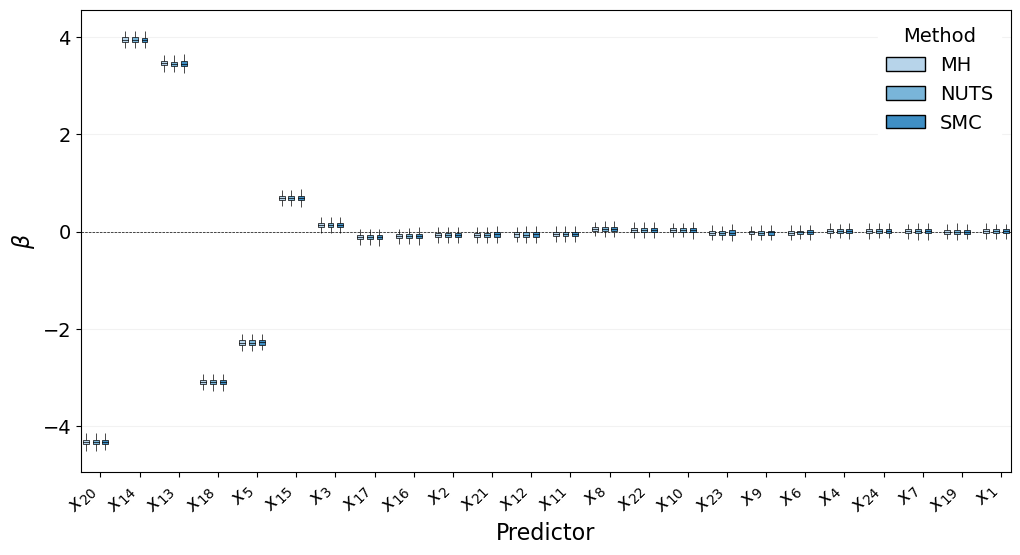

In [12]:
def boxplots_grouped(data, ylabel, labels=None):   

    # sort coefficients by magnitude
    ix = jnp.argsort(jnp.abs(jnp.mean(data[2, :, :], axis=0)))[::-1]
    data = data[:, :, ix]

    if labels == None:
        labels = [r'$x_{{{:d}}}$'.format(i+1) for i in ix]
    else:
        labels = [labels[i] for i in ix]

    M = data.shape[0]
    group_width = M + 1  
    positions = []
    for group in range(p):
        start_pos = group * group_width
        positions.extend([start_pos + m for m in range(M)])

    colors = plt.get_cmap('Blues')(jnp.linspace(0.3, 0.8, M+1))

    _, ax = plt.subplots(figsize=(12, 6))
    ax.axhline(y=0, ls='--', c='k', lw=0.5)
    ax.grid(which='both', axis='y', color='0.95')

    for i in range(p):
        for m in range(M):
            pos = i * M + m
            ax.boxplot(data[m, :, i], 
                       positions=[positions[pos]], 
                       widths=0.6, 
                       patch_artist=True,
                       boxprops=dict(facecolor=colors[m],
                                     linewidth=0.5),
                       showcaps=False,
                       medianprops=dict(color='k',
                                        linestyle='-',
                                        linewidth=0.5),
                       whiskerprops=dict(solid_capstyle='butt', 
                                         linewidth=0.5),
                       showfliers=False)

    legend_handles = [mpatches.Patch(facecolor=colors[m], edgecolor='k', label=methods[m]) for m in range(M)]
    ax.legend(handles=legend_handles, fontsize=SMALL_SIZE, edgecolor='w', facecolor='w', framealpha=1.0, title='Method')

    ax.set_xticks(jnp.arange(p) * group_width + M/2)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('Predictor', fontsize=MEDIUM_SIZE)
    ax.set_ylabel(ylabel, fontsize=MEDIUM_SIZE)

#
boxplots_grouped(samples_merged['beta'], r'$\beta$')

In this simulation, SMC converges most quickly (requiring around 20 seconds), compared a little under 3 minutes for Metropolis-MCMC and NUTS-HMC, respectively. All methods achieve convergence and agree in their estimates.

As we can see from the results in the paper (Figure 3), the comparison results depend on the dataset; for the actual depression dataset we find that NUTS was most efficient instead.